# First Exploration of Simulated COMCAM

- author : Sylvie Dagoret-Campagne
- creation date :  2024-04-04
- update : 2024-04-08
- w_2024_10

### Schema for data
- https://dm.lsst.org/sdm_schemas/browser/imsim.html

In [1]:
from lsst.daf.butler import Butler
import lsst
from lsst.geom import Angle 
import pandas as pd
import numpy as np
repo = '/repo/embargo'
instrument = 'LSSTComCamSim'
where_clause = "instrument = \'" + f"{instrument}" +"\'"
skymap_name = "ops_rehersal_prep_2k_v1"
#collection = 'LSSTComCamSim/quickLook/24'
collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collection4 = 'LSSTComCamSim/runs/nightlyvalidation/20240405/d_2024_03_29/DM-43612'
#collection = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collection = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collections = [collection1,collection2]
collections = [collection1,collection2,collection3]
butler = Butler(repo, collections=collections)
registry = butler.registry
from collections import OrderedDict

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
# Astropy
from astropy.visualization import ZScaleInterval, AsinhStretch

import seaborn as sns
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'

In [3]:
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import coordinates
import astropy.coordinates as coord
import astropy.units as u

In [4]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collections).any(execute=False, exact=False):
        # Limit search results to the data products
        if ('_config' not in datasetType.name) and ('_log' not in datasetType.name) and ('_metadata' not in datasetType.name) and ('_resource_usage' not in datasetType.name):
            print(datasetType)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
DatasetType('skyMap', {skymap}, SkyMap)
DatasetType('atlas_refcat2_20220201', {htm7}, SimpleCatalog)
DatasetType('packages', {}, Packages)
DatasetType('icSrc_schema', {}, SourceCatalog)
DatasetType('src_schema', {}, SourceCatalog)
DatasetType('icSrc', {band, instrument, detector, physical_filter, visit}, SourceCatalog)
DatasetType('icExpBackground', {band, instrument, detector, physical_filter, visit}, Background)
DatasetType('icExp', {band, instrument, detector, physical_filter, visit}, ExposureF)
DatasetType('postISRCCD', {band, instrumen

## How do I figure out which tracts have data?

In [5]:
for dtype in sorted(registry.queryDatasetTypes(expression="*nImage*")):
    print(dtype.name)

deepCoadd_nImage
goodSeeingCoadd_nImage


In [6]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [7]:
tracts = np.unique([ref.dataId['tract'] for ref in nImage_refs])
print(tracts)

bands = np.unique([ref.dataId['band'] for ref in nImage_refs])
print(bands)

[2494 2495 2661 2662 3200 3345 3346 3384 3385 3533 3534 6914 6915 7148
 7149 7445 7446 7683 7684 9347 9348 9570 9590 9591 9637 9638 9812 9813
 9880 9881]
['g' 'i' 'r']


In [8]:
tract_sel = tracts[0]

In [9]:
dict_tract_to_coords_deg = OrderedDict()
dict_tract_to_coords_rad = OrderedDict()
skymap = butler.get('skyMap', skymap=skymap_name)
for tract_sel in tracts:
    the_tract = skymap.generateTract(tract_sel)
    sp2 = the_tract.getCtrCoord() # get a SpherePoint(278.7804878048781*degrees, -48.34710743801652*degrees)
    dict_tract_to_coords_deg[tract_sel] = sp2
    dict_tract_to_coords_rad[tract_sel] = dict(ra = sp2[0].asRadians(), dec = sp2[1].asRadians() )

In [10]:
#for key, value in dict_tract_To_Coords.items():
#    print(key, "->", value,  " <=> (", value[0].asRadians()," , ", value[1].asRadians(), ")")

In [43]:
dict_tract_to_coords_deg 

OrderedDict([(2494,
              SpherePoint(278.7804878048781*degrees, -48.34710743801652*degrees)),
             (2495,
              SpherePoint(280.9756097560976*degrees, -48.34710743801652*degrees)),
             (2661,
              SpherePoint(278.57142857142856*degrees, -46.85950413223141*degrees)),
             (2662,
              SpherePoint(280.7142857142857*degrees, -46.85950413223141*degrees)),
             (3200,
              SpherePoint(300.33149171270713*degrees, -42.39669421487603*degrees)),
             (3345,
              SpherePoint(223.7837837837838*degrees, -40.90909090909091*degrees)),
             (3346,
              SpherePoint(225.7297297297297*degrees, -40.90909090909091*degrees)),
             (3384,
              SpherePoint(299.6756756756757*degrees, -40.90909090909091*degrees)),
             (3385,
              SpherePoint(301.6216216216216*degrees, -40.90909090909091*degrees)),
             (3533,
              SpherePoint(224.76190476190476*degree

In [11]:
dict_tract_to_coords_rad

OrderedDict([(2494, {'ra': 4.865637402511021, 'dec': -0.8438162086088287}),
             (2495, {'ra': 4.903949508042604, 'dec': -0.8438162086088287}),
             (2661, {'ra': 4.861988630555632, 'dec': -0.8178526329593263}),
             (2662, {'ra': 4.899388543098368, 'dec': -0.8178526329593263}),
             (3200, {'ra': 5.2417733778128035, 'dec': -0.739961906010819}),
             (3345, {'ra': 3.9057638395981216, 'dec': -0.7139983303613165}),
             (3346, {'ra': 3.9397270034207135, 'dec': -0.7139983303613165}),
             (3384, {'ra': 5.230327228679223, 'dec': -0.7139983303613165}),
             (3385, {'ra': 5.264290392501816, 'dec': -0.7139983303613165}),
             (3533, {'ra': 3.9228352711491596, 'dec': -0.6880347547118142}),
             (3534, {'ra': 3.9560796378538132, 'dec': -0.6880347547118142}),
             (6914, {'ra': 2.174948760177549, 'dec': -0.27261754431977536}),
             (6915, {'ra': 2.201799979439, 'dec': -0.27261754431977536}),
         

In [12]:
# Check which tracts actually have a lot of visit coverage:
dict_tract_to_coords_andvisits = OrderedDict()
for tract_sel in tracts:
    visits = list(butler.registry.queryDatasets('visitSummary', tract=tract_sel, skymap=skymap_name, findFirst=True))
    Nvis = len(visits)
    dict_tract_to_coords_andvisits[tract_sel] = dict(ra_deg=dict_tract_to_coords_deg[tract_sel][0], dec_deg =dict_tract_to_coords_deg[tract_sel][1] , 
                                                     ra_rad = dict_tract_to_coords_rad[tract_sel]["ra"], dec_rad = dict_tract_to_coords_rad[tract_sel]["dec"],nvis=Nvis)
    

In [13]:
dict_tract_to_coords_andvisits

OrderedDict([(2494,
              {'ra_deg': Angle(278.78048780487808, degrees),
               'dec_deg': Angle(-48.347107438016522, degrees),
               'ra_rad': 4.865637402511021,
               'dec_rad': -0.8438162086088287,
               'nvis': 1140}),
             (2495,
              {'ra_deg': Angle(280.97560975609758, degrees),
               'dec_deg': Angle(-48.347107438016522, degrees),
               'ra_rad': 4.903949508042604,
               'dec_rad': -0.8438162086088287,
               'nvis': 1526}),
             (2661,
              {'ra_deg': Angle(278.57142857142856, degrees),
               'dec_deg': Angle(-46.859504132231407, degrees),
               'ra_rad': 4.861988630555632,
               'dec_rad': -0.8178526329593263,
               'nvis': 310}),
             (2662,
              {'ra_deg': Angle(280.71428571428572, degrees),
               'dec_deg': Angle(-46.859504132231407, degrees),
               'ra_rad': 4.899388543098368,
               

## visitSummary

In [14]:
if 0:

    all_data = []
    data_product = 'visitSummary'

    #datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= "instrument='LSSTComCamSim'")
    datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where = where_clause)
    for i, ref in enumerate(datasetRefs):
        if (i % 100 == 0):
            print(f"======================== datasetType = {data_product} ============================================")
            print("fullId..................:",ref.dataId.full)
        try:
            data = butler.get(data_product, dataId=ref.dataId )  
            all_data.append(data)
       
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)         

    N = len(all_data)
    print(f"{visitSummary} :: N = {N}")

### CCD VisitTable

In [15]:
list(butler.registry.queryDatasets('ccdVisitTable'))

[DatasetRef(DatasetType('ccdVisitTable', {instrument}, DataFrame), {instrument: 'LSSTComCamSim'}, run='LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612/20240404T170540Z', id=56b62564-4b20-4e5b-9d5b-568d5b06655c)]

In [16]:
ccdVisitTable = butler.get('ccdVisitTable')

In [17]:
ccdVisitTable.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'effTime',
       'effTimePsfSigmaScale', 'effTimeSkyBgScale', 'effTimeZeroPointScale',
       'decl', 'detector', 'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD',
       'expTime', 'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize',
       'llcra', 'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra',
       'lrcdec'],
      dtype='object')

In [18]:
# https://pipelines.lsst.io/modules/lsst.geom/getting-started.html
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_zendtoAirmass = lambda x : 1./np.cos(func_degToRad(x))
#func_wrap = lambda x : Angle(x,lsst.geom.radians).wrap(180.*lsst.geom.degrees)

In [19]:
ccdVisitTable["airmass"] = ccdVisitTable['zenithDistance'].apply(func_zendtoAirmass)

Text(0, 0.5, 'zeroPoint')

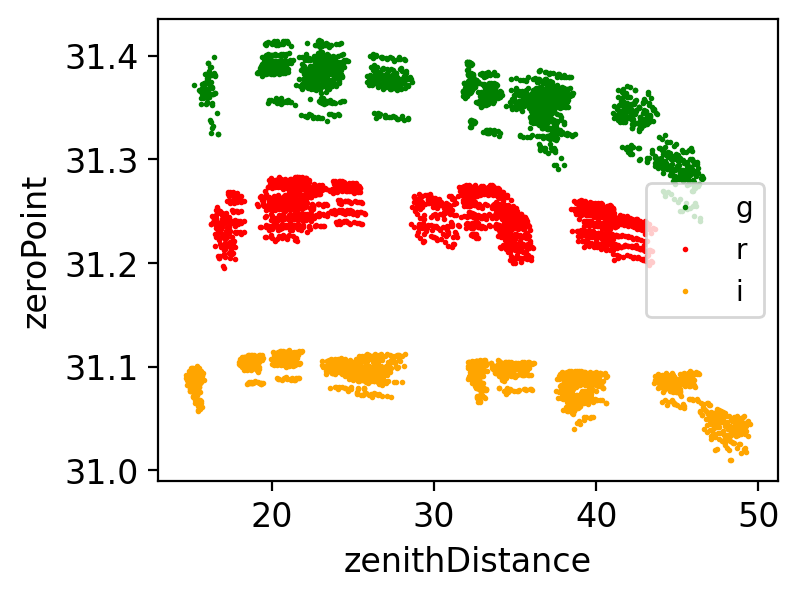

In [20]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['zenithDistance'][in_band], ccdVisitTable['zeroPoint'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('zenithDistance')
plt.ylabel('zeroPoint')

Text(0, 0.5, 'zeroPoint')

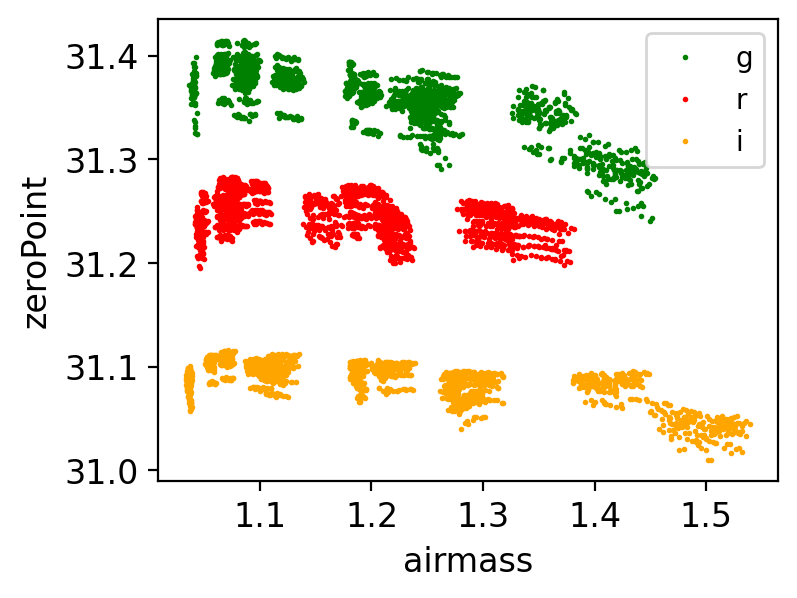

In [21]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['airmass'][in_band], ccdVisitTable['zeroPoint'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('airmass')
plt.ylabel('zeroPoint')

Text(0, 0.5, 'psfSigma')

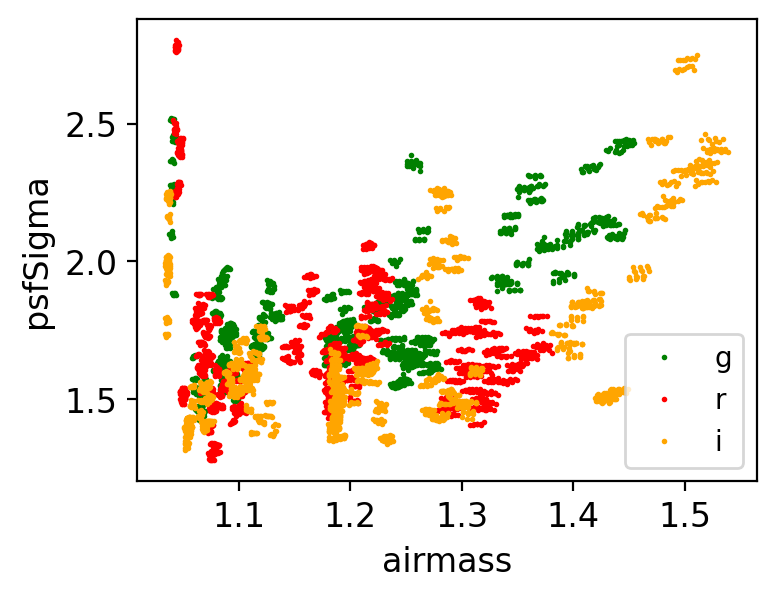

In [22]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['airmass'][in_band], ccdVisitTable['psfSigma'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('airmass')
plt.ylabel('psfSigma')

Text(0, 0.5, 'seeing')

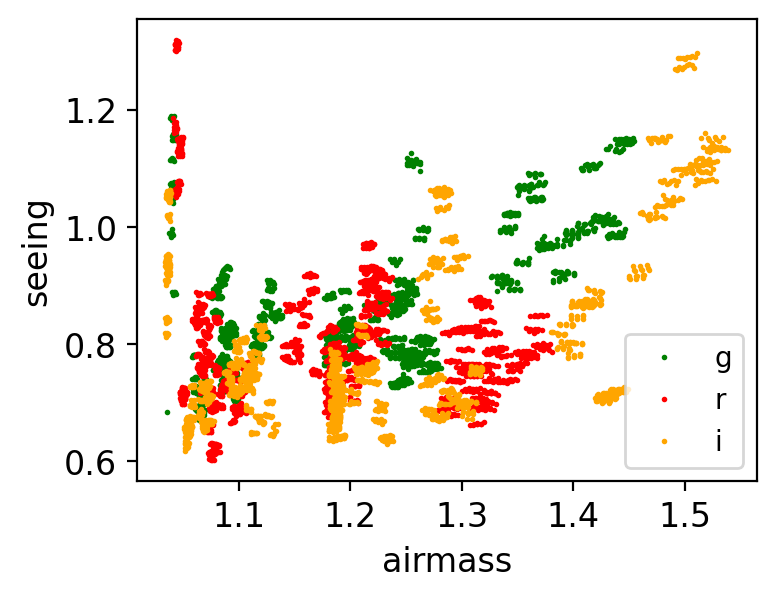

In [23]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['airmass'][in_band], ccdVisitTable['seeing'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('airmass')
plt.ylabel('seeing')

In [24]:
ccdvisit_subset = ccdVisitTable[['visitId', 'band', 'ra', 'dec','detector','zenithDistance','obsStartMJD']]

In [25]:
ccdvisit_subset 

,visitId,band,ra,dec,detector,zenithDistance,obsStartMJD
ccdVisitId,,,,,,,
730865860864,7024040300001,r,124.617999,-15.026212,0,17.825243,60403.979335
730865860865,7024040300001,r,124.745824,-14.826505,1,18.059967,60403.979335
730865860866,7024040300001,r,124.873418,-14.626731,2,18.294695,60403.979335
730865860867,7024040300001,r,124.824851,-15.149693,3,17.819584,60403.979335
730865860868,7024040300001,r,124.952564,-14.949870,4,18.054384,60403.979335
...,...,...,...,...,...,...,...
730866060292,7024040300780,r,299.857944,-40.858541,4,19.874241,60404.435870
730866060293,7024040300780,r,300.072069,-40.688646,5,19.948414,60404.435870
730866060294,7024040300780,r,299.867703,-41.190589,6,20.026587,60404.435870


In [26]:
# https://pipelines.lsst.io/modules/lsst.geom/getting-started.html
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_zendtoAirmass = lambda x : 1./np.cos(func_degToRad(x))
#func_wrap = lambda x : Angle(x,lsst.geom.radians).wrap(180.*lsst.geom.degrees)

In [27]:
ccdvisit_subset["zenithDistance_rad"]= ccdvisit_subset["zenithDistance"].apply(func_degToRad)
ccdvisit_subset["airmass"]= ccdvisit_subset["zenithDistance"].apply(func_zendtoAirmass)

/tmp/ipykernel_6275/3502715768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdvisit_subset["zenithDistance_rad"]= ccdvisit_subset["zenithDistance"].apply(func_degToRad)
/tmp/ipykernel_6275/3502715768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdvisit_subset["airmass"]= ccdvisit_subset["zenithDistance"].apply(func_zendtoAirmass)


In [28]:
ccdvisit_subset

,visitId,band,ra,dec,detector,zenithDistance,obsStartMJD,zenithDistance_rad,airmass
ccdVisitId,,,,,,,,,
730865860864,7024040300001,r,124.617999,-15.026212,0,17.825243,60403.979335,0.311109,1.050426
730865860865,7024040300001,r,124.745824,-14.826505,1,18.059967,60403.979335,0.315206,1.051820
730865860866,7024040300001,r,124.873418,-14.626731,2,18.294695,60403.979335,0.319303,1.053236
730865860867,7024040300001,r,124.824851,-15.149693,3,17.819584,60403.979335,0.311010,1.050393
730865860868,7024040300001,r,124.952564,-14.949870,4,18.054384,60403.979335,0.315108,1.051787
...,...,...,...,...,...,...,...,...,...
730866060292,7024040300780,r,299.857944,-40.858541,4,19.874241,60404.435870,0.346871,1.063331
730866060293,7024040300780,r,300.072069,-40.688646,5,19.948414,60404.435870,0.348166,1.063830
730866060294,7024040300780,r,299.867703,-41.190589,6,20.026587,60404.435870,0.349530,1.064358


In [29]:
#ccdvisit_subset_u = ccdvisit_subset[ccdvisit_subset.band == 'u']
ccdvisit_subset_g = ccdvisit_subset[ccdvisit_subset.band == 'g']
ccdvisit_subset_r = ccdvisit_subset[ccdvisit_subset.band == 'r']
ccdvisit_subset_i = ccdvisit_subset[ccdvisit_subset.band == 'i']
#ccdvisit_subset_z = ccdvisit_subset[ccdvisit_subset.band == 'z']
#ccdvisit_subset_y = ccdvisit_subset[ccdvisit_subset.band == 'y']
Ng = len(ccdvisit_subset_g)
Nr = len(ccdvisit_subset_r)
Ni = len(ccdvisit_subset_i)
print(Ng,Nr,Ni)

2015 2172 2114


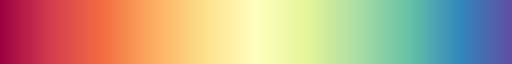

In [30]:
sns.color_palette("Spectral", as_cmap=True)

In [31]:
cmap_g = ListedColormap(sns.color_palette("Spectral", Ng))
cmap_r = ListedColormap(sns.color_palette("Spectral", Nr))
cmap_i = ListedColormap(sns.color_palette("Spectral", Ni))

#patch_to_color[patch] = cmap.colors[idx]

In [32]:
all_colors_g = [cmap_g.colors[idx] for idx in range(Ng)]
all_colors_r = [cmap_r.colors[idx] for idx in range(Nr)]
all_colors_i = [cmap_i.colors[idx] for idx in range(Ni)]

In [33]:
ra_g = ccdvisit_subset_g['ra'].apply(func_degToRad) 
dec_g = ccdvisit_subset_g['dec'].apply(func_degToRad) 

In [34]:
# Galactic plane
gal_long = np.linspace(-180.,180,360)
gal_lat = np.zeros((360))
coordinates_galactic_planes = SkyCoord(l=gal_long*u.degree, b=gal_lat*u.degree, frame='galactic')
gp_radec = coordinates_galactic_planes.transform_to('icrs')  
# for galactic plane
# gp_radec.ra : 0., 360.
# gp_radec.dec : -90, 90
gp_ra_toplot = coordinates.Angle(gp_radec.ra.degree*u.degree)
gp_ra_toplot = gp_ra_toplot.wrap_at(180*u.degree)
# gp_ra_toplot -180, 180
#wrapping angle : https://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html

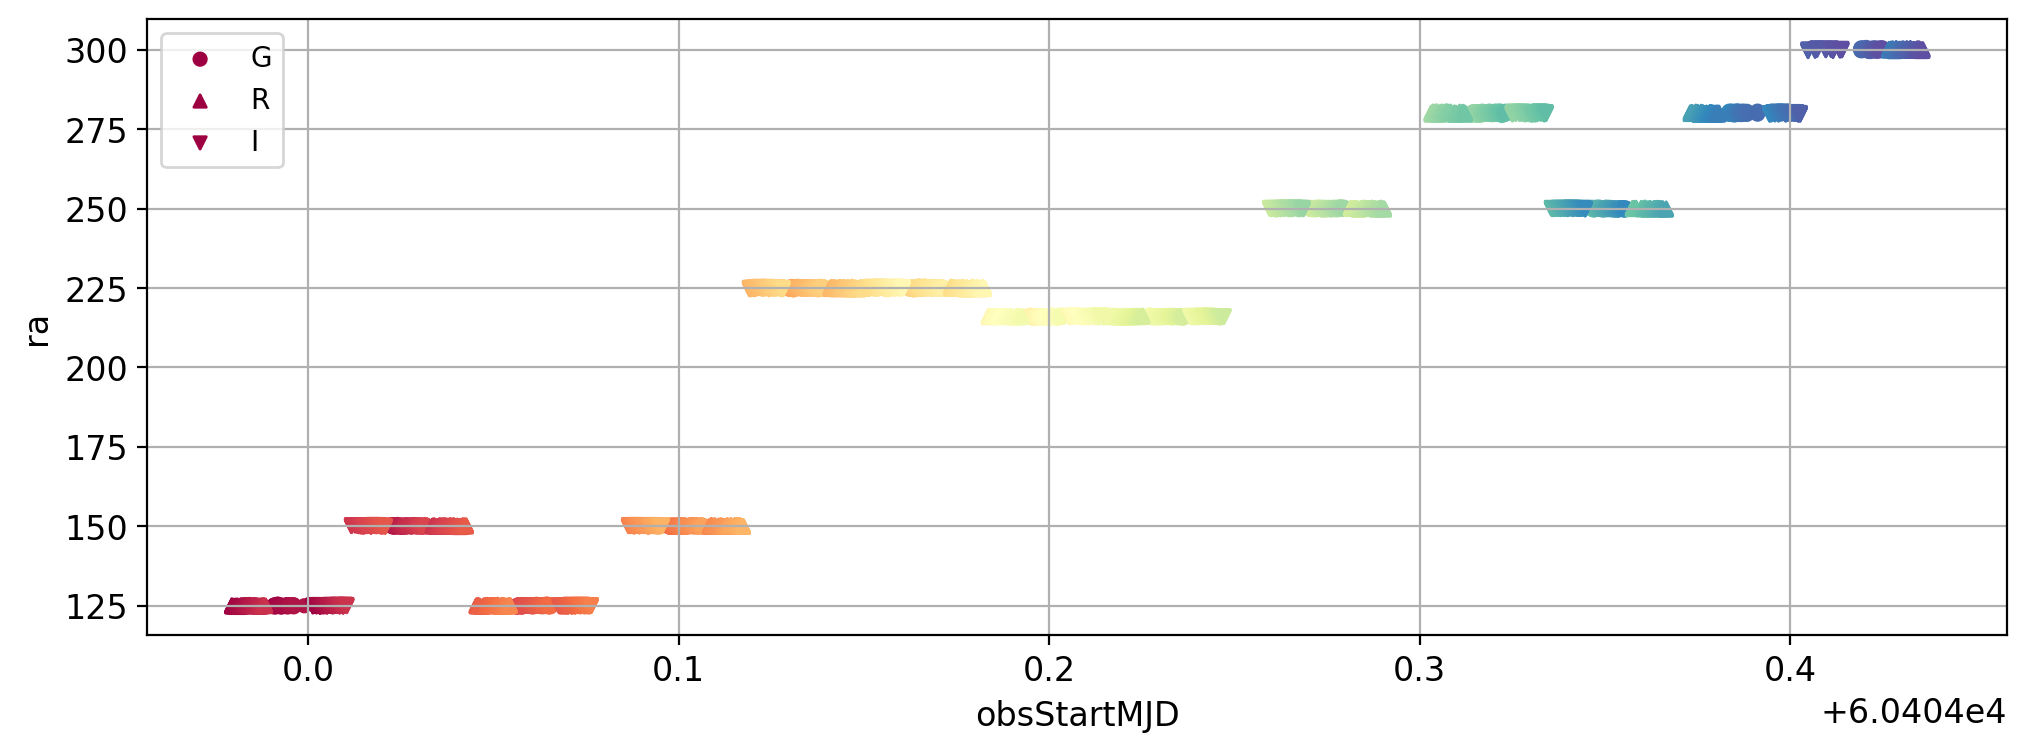

In [35]:
fig,ax = plt.subplots(1,1,figsize=(12,4),dpi=200)
#ax.scatter(ccdvisit_subset_g["obsStartMJD"].values,ccdvisit_subset_g["ra"].values ,c=all_colors_g)
ccdvisit_subset_g.plot.scatter(x="obsStartMJD",y="ra",marker="o",c=all_colors_g,ax=ax,label="G")
ccdvisit_subset_r.plot.scatter(x="obsStartMJD",y="ra",marker="^",c=all_colors_r,ax=ax,label="R")
ccdvisit_subset_i.plot.scatter(x="obsStartMJD",y="ra",marker="v",c=all_colors_i,ax=ax,label="I")
ax.grid()

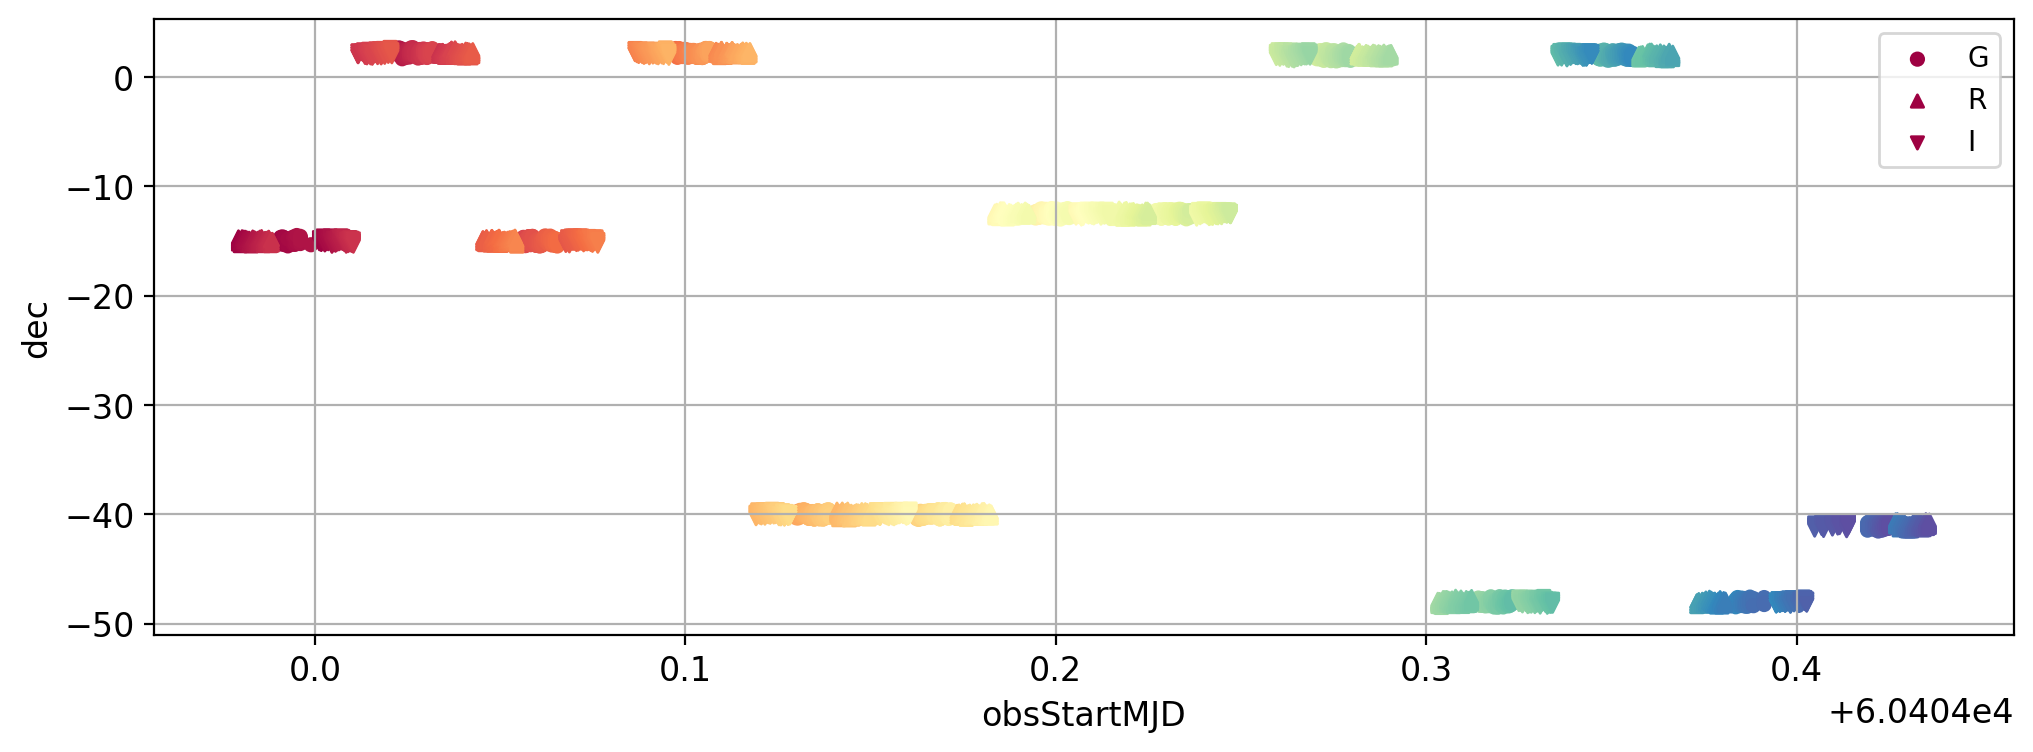

In [36]:
fig,ax = plt.subplots(1,1,figsize=(12,4),dpi=200)
#ax.scatter(ccdvisit_subset_g["obsStartMJD"].values,ccdvisit_subset_g["ra"].values ,c=all_colors_g)
ccdvisit_subset_g.plot.scatter(x="obsStartMJD",y="dec",marker="o",c=all_colors_g,ax=ax,label="G")
ccdvisit_subset_r.plot.scatter(x="obsStartMJD",y="dec",marker="^",c=all_colors_r,ax=ax,label="R")
ccdvisit_subset_i.plot.scatter(x="obsStartMJD",y="dec",marker="v",c=all_colors_i,ax=ax,label="I")
ax.grid()

In [37]:
dict_tract_to_coords_rad

OrderedDict([(2494, {'ra': 4.865637402511021, 'dec': -0.8438162086088287}),
             (2495, {'ra': 4.903949508042604, 'dec': -0.8438162086088287}),
             (2661, {'ra': 4.861988630555632, 'dec': -0.8178526329593263}),
             (2662, {'ra': 4.899388543098368, 'dec': -0.8178526329593263}),
             (3200, {'ra': 5.2417733778128035, 'dec': -0.739961906010819}),
             (3345, {'ra': 3.9057638395981216, 'dec': -0.7139983303613165}),
             (3346, {'ra': 3.9397270034207135, 'dec': -0.7139983303613165}),
             (3384, {'ra': 5.230327228679223, 'dec': -0.7139983303613165}),
             (3385, {'ra': 5.264290392501816, 'dec': -0.7139983303613165}),
             (3533, {'ra': 3.9228352711491596, 'dec': -0.6880347547118142}),
             (3534, {'ra': 3.9560796378538132, 'dec': -0.6880347547118142}),
             (6914, {'ra': 2.174948760177549, 'dec': -0.27261754431977536}),
             (6915, {'ra': 2.201799979439, 'dec': -0.27261754431977536}),
         

In [ ]:
# plot
# x arg in rad must be (-2pi,2pi), y arg in rad  must be in ( -pi,pi )
fig = plt.figure(figsize=(12,6),dpi=200)
#ax = fig.add_subplot(111, projection="aitoff")
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="r",label="Galactic Plane",s=1)
ax.scatter(ra_g.values-np.pi,dec_g.values,marker='+',c=all_colors_g)
ax.legend()
ax.grid()

index=0
for key, value in dict_tract_to_coords_rad.items():
    tract_num_str= str(key)
    x = value["ra"] - np.pi
    y = value["dec"] 
    
    if index%2 == 0:
        dy= -Angle(2,lsst.geom.degrees).asRadians()
        dx= -Angle(3,lsst.geom.degrees).asRadians()
    else:
        dy= Angle(2,lsst.geom.degrees).asRadians()
        dx= Angle(3,lsst.geom.degrees).asRadians()
        
    #ax.text(x+dx, y+dy, tract_num_str, fontsize=5,color="b")
    index+=1

plt.suptitle(instrument)

## sourceTable_visit

In [39]:
if 0:
    all_data = []
    data_product = 'sourceTable_visit'
    datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= "instrument='LSSTComCamSim'")
    for i, ref in enumerate(datasetRefs):
        if (i % 500 == 0):
            print(f"======================== datasetType = {data_product} ============================================")
            print("fullId..................:",ref.dataId.full)
        try:
            data = butler.get(data_product, dataId=ref.dataId )  
            all_data.append(data)
       
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)       

    df = pd.concat(all_data)
    filename = f"out-{data_product}.csv" 
    df.to_csv(filename)

## How do I access an object table?

In [40]:
objectTable_refs = sorted(butler.registry.queryDatasets('objectTable_tract'))
N = len(objectTable_refs)
objectTable = butler.get(objectTable_refs[0])
objectTable[['coord_ra','coord_dec','tract','patch']]

column,coord_ra,coord_dec,tract,patch
objectId,,,,
792584056393957377,279.937732,-48.584537,2494,85
792584056393957378,279.940418,-48.584559,2494,85
792584056393957379,279.936037,-48.581862,2494,85
792584056393957380,279.943076,-48.582075,2494,85
792584056393957381,279.940426,-48.580578,2494,85
...,...,...,...,...
792795162626491461,279.264582,-47.568336,2494,277
792795162626491462,279.263681,-47.568158,2494,277
792795162626491463,279.258807,-47.568428,2494,277


In [41]:
list(objectTable.columns)

['deblend_skipped',
 'deblend_iterations',
 'refBand',
 'deblend_isolatedParent',
 'x',
 'y',
 'deblend_incompleteData',
 'merge_peak_sky',
 'shape_flag',
 'shape_yy',
 'detect_isDeblendedModelSource',
 'coord_dec',
 'detect_isPrimary',
 'detect_isTractInner',
 'detect_isPatchInner',
 'deblend_nPeaks',
 'coord_ra_dec_Cov',
 'sky_object',
 'shape_xy',
 'coord_ra',
 'parentObjectId',
 'coord_raErr',
 'footprintArea',
 'deblend_peak_center_y',
 'coord_decErr',
 'deblend_peak_center_x',
 'deblend_masked',
 'deblend_parentTooBig',
 'deblend_logL',
 'xy_flag',
 'shape_xx',
 'refFwhm',
 'ebv',
 'deblend_nChild',
 'deblend_failed',
 'deblend_tooManyPeaks',
 'detect_isIsolated',
 'detect_fromBlend',
 'xErr',
 'refSizeExtendedness',
 'detect_isDeblendedSource',
 'refExtendedness',
 'yErr',
 'tract',
 'patch',
 'g_ra',
 'g_dec',
 'g_decl',
 'g_raErr',
 'g_decErr',
 'g_ra_dec_Cov',
 'g_psfFlux',
 'g_psfFluxErr',
 'g_free_psfFlux',
 'g_free_psfFluxErr',
 'g_free_psfFlux_flag',
 'g_bdE1',
 'g_bdE2',

## preSourceTable

In [42]:
if 0:
    all_data = []
    data_product = 'preSourceTable'
    datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= "instrument='LSSTComCamSim'")
    for i, ref in enumerate(datasetRefs):
        if (i % 500 == 0):
            print(f"======================== datasetType = {data_product} ============================================")
            print("fullId..................:",ref.dataId.full)
        try:
            data = butler.get(data_product, dataId=ref.dataId )  
            all_data.append(data)
       
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)       

    df = pd.concat(all_data)
    filename = f"out-{data_product}.csv" 
    df.to_csv(filename)